[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025_2/blob/main/analysis_scripts/Original_Simulation.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025_2.git
%cd /content/OP_2025_2/analysis_scripts

In [ ]:
!pip install -qr requirements.txt

# Packages and functions

In [ ]:
import os
import time
import umap
import random
import numpy as np
import pandas as pd
import colorsys as cs
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.spatial import procrustes, distance_matrix
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cdist
import scipy
from itertools import chain, repeat
import anndata as ad

def get_pa(pos_recon, pos_truth):
    pos_recon = pd.DataFrame(pos_recon, columns = [['xcoord','ycoord']])
    mtx1, mtx2, disparity = procrustes(pos_truth[['xcoord','ycoord']], pos_recon[['xcoord','ycoord']])
    
    pos_truth_translate = pos_truth.copy()
    pos_truth_translate['xcoord'] = pos_truth_translate['xcoord'] - np.mean(pos_truth_translate['xcoord'])
    pos_truth_translate['ycoord'] = pos_truth_translate['ycoord'] - np.mean(pos_truth_translate['ycoord'])
    
    scaling = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))
    scaling_2 = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))/np.sqrt(np.trace(np.dot(mtx2, mtx2.T)))

    mtx1_scaled = mtx1*scaling
    mtx2_scaled = mtx2*scaling_2
    
    return mtx2_scaled

# Simulation of bead locations

In [16]:
np.random.seed(42)

# simulation parameters
n_a = 1000 # capture
n_t = 1000 # fiducial
RADIUS = 1500
sigma = 300
UMI = 300

# generate coordinates for capture and fiducial
r_vals = np.sqrt(np.random.uniform(size=n_t)) * RADIUS
thet_vals = np.random.uniform(size=n_t) * 2 * np.pi
coords_t_truth = np.column_stack((r_vals * np.cos(thet_vals), r_vals * np.sin(thet_vals)))
coords_t_truth = coords_t_truth.astype(float)
r_vals = np.sqrt(np.random.uniform(size=n_a)) * RADIUS
thet_vals = np.random.uniform(size=n_a) * 2 * np.pi
coords_a_truth = np.column_stack((r_vals * np.cos(thet_vals), r_vals * np.sin(thet_vals)))
coords_a_truth = coords_a_truth.astype(float)

## Simulation of Diffusion

In [17]:
distances = cdist(coords_a_truth, coords_t_truth)
proba = np.exp(-distances**2 / (2*sigma**2))
proba = proba / proba.sum(axis=1, keepdims=True)

# simulate counts data
counts = np.zeros((n_a, n_t))
for i in range(n_a):
    counts[i,:] = np.random.multinomial(UMI, proba[i,:])

In [18]:
adata = ad.AnnData(counts, obs = pd.DataFrame(coords_a_truth, columns=['xcoord', 'ycoord']), var = pd.DataFrame(coords_t_truth, columns=['xcoord', 'ycoord']))
adata


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1000 × 1000
    obs: 'xcoord', 'ycoord'
    var: 'xcoord', 'ycoord'

In [19]:
import scanpy as sc
from sklearn.metrics.pairwise import cosine_similarity

cos_counts = cosine_similarity(adata.X)
#log_cos_counts = cosine_similarity(np.log1p(adata.X))


In [20]:
truth_dist = distance_matrix(adata.obs.copy().values, adata.obs.copy().values)
truth_dist

array([[   0.        ,  574.7967162 , 2136.11460154, ..., 1229.28983207,
         684.00275001, 2166.34391924],
       [ 574.7967162 ,    0.        , 2152.81527953, ..., 1506.43221161,
        1155.31735239, 1973.28894815],
       [2136.11460154, 2152.81527953,    0.        , ..., 1124.33663295,
        1765.354366  ,  781.82027946],
       ...,
       [1229.28983207, 1506.43221161, 1124.33663295, ...,    0.        ,
         678.18082032, 1552.87932148],
       [ 684.00275001, 1155.31735239, 1765.354366  , ...,  678.18082032,
           0.        , 2036.44690568],
       [2166.34391924, 1973.28894815,  781.82027946, ..., 1552.87932148,
        2036.44690568,    0.        ]])

# Reconstruction with UMAP

## With Raw Counts

In [21]:
time_start = time.time()
reducer = umap.UMAP(metric='cosine',
                    n_neighbors=25, 
                    min_dist=0.99, 
                    low_memory=False, 
                    n_components=2, 
                    verbose=True,           
                    n_epochs=10000,                    
                    learning_rate = 1)
embedding = reducer.fit_transform(adata.X)
time_loop = time.time()
print('umap time: ', time_loop-time_start)

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, learning_rate=1, low_memory=False, metric='cosine', min_dist=0.99, n_epochs=10000, n_neighbors=25, verbose=True)
Tue Dec 16 16:55:47 2025 Construct fuzzy simplicial set
Tue Dec 16 16:55:48 2025 Finding Nearest Neighbors
Tue Dec 16 16:55:48 2025 Finished Nearest Neighbor Search
Tue Dec 16 16:55:48 2025 Construct embedding


Epochs completed:   0%|            0/10000 [00:00]

	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Tue Dec 16 16:55:54 2025 Finished embedding
umap time:  6.520625829696655


# accumap Proof of Concept (perfect distances)

## Rescale embeddings

In [22]:
embedding

array([[28.360779 ,  7.2262044],
       [32.45065  ,  5.6915216],
       [24.00296  , -6.4822216],
       ...,
       [22.647882 ,  0.9109502],
       [23.961864 ,  5.3693657],
       [29.292908 , -6.853563 ]], dtype=float32)

In [23]:
embedding = embedding - np.mean(embedding, axis=0)
embedding = embedding*RADIUS*2/np.max(distance_matrix(embedding, embedding))
embedding

array([[  -20.47256256,   819.08251844],
       [  606.4815749 ,   583.82424618],
       [ -688.5016538 , -1282.3422307 ],
       ...,
       [ -896.22751664,  -149.01048453],
       [ -694.80139419,   534.43955304],
       [  122.41756458, -1339.26674192]])

## Run Accumap on raw count umap embedding

In [ ]:
import time
from accumap import * 

def main():
    # Resize to truth distance
    black_df = pd.DataFrame(embedding, columns = ['xcoord', 'ycoord'])
    time_start = time.time()
    x = 0
    while x < 1:
        black_df = correct_locations(black_df,  truth_dist, n_jobs=64,
                                                           verbose_step = 200, update_interval=1, correct_order='random',
                                                           weight = cos_counts)
        x += 1
    time_loop = time.time()
    print('accumap time: ', time_loop-time_start)
    black_df.to_csv('og_sim_raw_truth.csv')
# Required for multiprocessing
if __name__ == "__main__":
    main()

200 completed
400 completed
600 completed
800 completed
1000 completed
accumap time:  1.7320821285247803


# Evaluate accuracy of all methods

## Nearest Neighbor Accuracy

In [25]:
from sklearn.neighbors import KDTree
from numba import njit

@njit
def unique_sorted(a):
    """Return unique sorted values of array a (Numba-compatible)."""
    a = np.sort(a)
    out = [a[0]]
    for i in range(1, a.size):
        if a[i] != a[i-1]:
            out.append(a[i])
    return np.array(out)

@njit
def count_intersection(a, b):
    """Count unique intersection between two sorted unique arrays."""
    i = j = count = 0
    na, nb = a.size, b.size
    while i < na and j < nb:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            i += 1
        else:
            j += 1
    return count

@njit
def count_union_size(a, b):
    """Count unique union size of two sorted unique arrays."""
    i = j = count = 0
    na, nb = a.size, b.size
    while i < na and j < nb:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            count += 1
            i += 1
        else:
            count += 1
            j += 1
    # Add remaining items
    count += (na - i) + (nb - j)
    return count

@njit
def jaccard_distance_numeric_numba(X, Y):
    n = X.shape[0]
    out = np.empty(n, dtype=np.float64)

    for idx in range(n):
        x = unique_sorted(X[idx])
        y = unique_sorted(Y[idx])

        inter = count_intersection(x, y)
        union = count_union_size(x, y)

        out[idx] = 1.0 - (inter / union if union != 0 else 0.0)

    return out


In [26]:
raw_accumap = pd.read_csv('og_sim_raw_truth.csv', index_col=0)


embed_list = [embedding, raw_accumap]
name_list = ['UMAP Embedding','Perfect Information Accumap']
nn_list = np.arange(2, 25, 1).tolist() 


bar_n = adata.obs.shape[0]
jac_list = []
nn_df_list = []
method_list = []

truth_tree = KDTree(adata.obs[['xcoord', 'ycoord']].values)

for embed, name in zip(embed_list, name_list):
    print(name)
    embed_tree = KDTree(embed)
    for nn in nn_list:
        distances, truth_nn = truth_tree.query(adata.obs[['xcoord', 'ycoord']].values, k=nn)

        distances, test_nn = embed_tree.query(embed, k=nn)
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test_nn[:, 1:nn]).tolist()
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]

UMAP Embedding
Perfect Information Accumap


In [27]:
embed_list = [cos_counts]
name_list = ['Cosine Similarity of Bead Counts']

for c, name in zip(embed_list, name_list):
    test = c.argsort(axis=1)[:, ::-1]
    print(name)
    for nn in nn_list:
        distances, truth_nn = truth_tree.query(adata.obs[['xcoord', 'ycoord']].values, k=nn)
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test[:, 1:nn]).tolist() 
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]


median_nn = pd.DataFrame({'nn':nn_df_list,
                         'method':method_list,
                         'jac':jac_list})
median_nn.head()

Cosine Similarity of Bead Counts


,nn,method,jac
0,1,UMAP Embedding,1.0
1,1,UMAP Embedding,0.0
2,1,UMAP Embedding,1.0
3,1,UMAP Embedding,1.0
4,1,UMAP Embedding,0.0


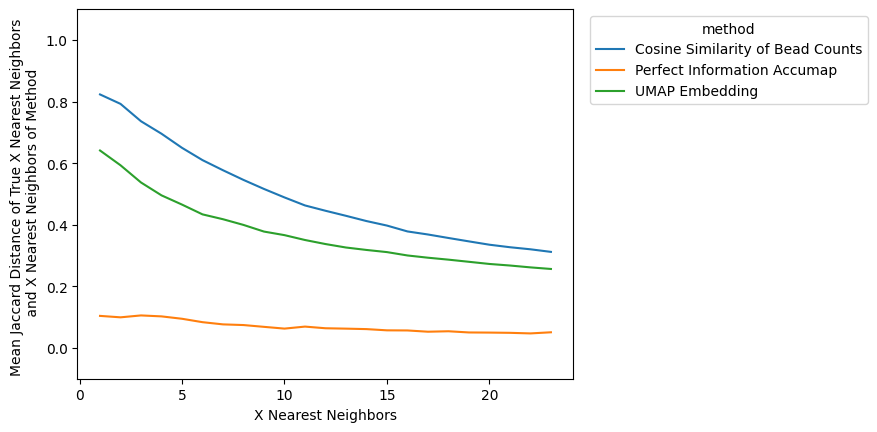

In [28]:
ax = sns.lineplot(median_nn.groupby(['method', 'nn']).mean().reset_index(), x = 'nn', y = 'jac', hue = 'method'#, style = 'method'
         )
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1.02, 1))
ax.set_xlabel('X Nearest Neighbors')
ax.set_ylabel('Mean Jaccard Distance of True X Nearest Neighbors \n and X Nearest Neighbors of Method')

plt.ylim(-0.1, 1.1)
plt.show()

## Distance Matrix Accuracy

In [29]:
def get_error_metrics(embedding, truth_pos, mean_err = True):
    embedding_df = get_pa(embedding, truth_pos)
    embed_dist = distance_matrix(embedding_df, embedding_df)
    
    truth_dist = distance_matrix(truth_pos.values, truth_pos.values)
    if mean_err:
        error = np.mean(np.square(np.subtract(truth_dist, embed_dist)), axis=0)
    else: 
        error = np.square(np.subtract(truth_dist, embed_dist))
    return error

In [30]:


embed_list = [embedding, raw_accumap.values]
name_list = ['UMAP Embedding', 'Perfect Information Accumap']

bar_n = adata.obs.shape[0]
error_list = []
method_list = []
bead_list = len(embed_list)* np.arange(bar_n).tolist()

for embed, name in zip(embed_list, name_list):
    print(name)
    error_list += get_error_metrics(embed, adata.obs[['xcoord', 'ycoord']]).tolist()
    method_list += bar_n*[name]

error_df = pd.DataFrame({'error':error_list,
                         'method':method_list,
                         'bead':bead_list})
error_df.head()

UMAP Embedding
Perfect Information Accumap


,error,method,bead
0,2264.261517,UMAP Embedding,0
1,4152.222395,UMAP Embedding,1
2,2077.390319,UMAP Embedding,2
3,2113.875381,UMAP Embedding,3
4,2592.563952,UMAP Embedding,4


In [31]:
error_df.groupby('method')['error'].mean()

method
Perfect Information Accumap     398.670798
UMAP Embedding                 4101.174069
Name: error, dtype: float64

In [32]:
error_df.groupby('method')['error'].median()

method
Perfect Information Accumap     340.301982
UMAP Embedding                 3254.149902
Name: error, dtype: float64

# Curvefit on Data subset

In [33]:
import scanpy as sc
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

In [34]:
np.random.seed(42)
# Pre-load coordinates to avoid repeated pandas lookup
cutoff = 0

# Pre-sample some amount of counts
bars = np.random.randint(0, adata.shape[0], 10)

In [35]:
test_df = pd.DataFrame({
                       'cosine similarity' : cos_counts[bars].flatten().tolist(),
                       'distance' : truth_dist[bars].flatten().tolist(),
                       'cell' : bars.tolist()*adata.shape[0]})
test_df.head()

,cosine similarity,distance,cell
0,0.039952,947.301591,102
1,0.369065,505.065791,435
2,0.000000,1808.202874,860
3,0.021308,1066.438599,270
4,0.003480,1216.888793,106


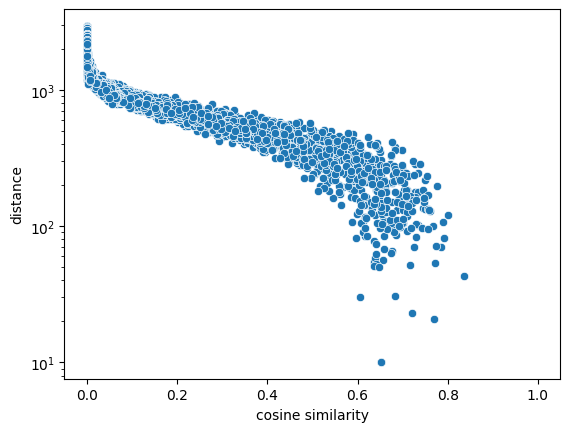

In [36]:
ax = sns.scatterplot(test_df, x = 'cosine similarity', y = 'distance', #hue = 'count',
                    )
plt.yscale('log')

In [37]:
def diff_func(x, A, B, C, D):
    return D - C * np.log(-(A+B-x)/(A-x))

In [38]:
cos_filter_num = 0
fitting_df = test_df[(test_df['cosine similarity'] > cos_filter_num) #& (test_df.distance != 0)
]
popt, pcov = curve_fit(
                        diff_func,
                        fitting_df['cosine similarity'].values, fitting_df.distance.values,
                        p0=(-5.38922863e-03,  1.10386516e+00,  2.96239346e+02,  7.83921914e+02),
                        #bounds=(0, np.inf),
                        maxfev=20000
                    )
popt

/tmp/ipykernel_1698983/539690614.py:2: RuntimeWarning: invalid value encountered in log
  return D - C * np.log(-(A+B-x)/(A-x))


array([-2.56509592e-03,  1.06819498e+00, -2.04939902e+02,  3.61560021e+02])

In [39]:
diff_func(1, *popt)

np.float64(-197.16475291938264)

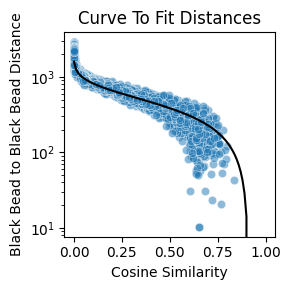

In [ ]:
plt.figure(figsize=(3, 3))
sns.scatterplot(test_df, x = 'cosine similarity', y = 'distance', #hue = 'cell', 
                alpha = .5)
plt.plot(np.arange(0, 1, .01), diff_func(np.array(np.arange(0, 1, .01)), *popt), color = 'black')

plt.title('Curve To Fit Distances')
plt.yscale('log')
plt.ylabel('Black Bead to Black Bead Distance')
plt.xlabel('Cosine Similarity')
plt.tight_layout()
plt.savefig('../final_figures/Supp2b.png')

# Apply Fit to full Data

In [41]:
def vector_diff_func(x, final_var, min_count):
    mask = x > min_count
    out = np.empty_like(x, dtype=float)
    out[mask]  = diff_func(x[mask], *final_var)
    # enforce a maximum distance
    out[~mask] = 3000
    # enforce a minimum distance
    out[out <= 10] = 10
    np.fill_diagonal(out, 0)
    return out
    
fit_dist = vector_diff_func(cos_counts, popt, cos_filter_num)
fit_dist

array([[   0.        ,  649.63954729, 3000.        , ..., 1217.47221538,
         685.31048911, 3000.        ],
       [ 649.63954729,    0.        , 3000.        , ..., 1466.50302628,
        1194.38036827, 3000.        ],
       [3000.        , 3000.        ,    0.        , ..., 1036.14411308,
        1536.02159532,  649.2996548 ],
       ...,
       [1217.47221538, 1466.50302628, 1036.14411308, ...,    0.        ,
         638.0361604 , 1486.2962183 ],
       [ 685.31048911, 1194.38036827, 1536.02159532, ...,  638.0361604 ,
           0.        , 3000.        ],
       [3000.        , 3000.        ,  649.2996548 , ..., 1486.2962183 ,
        3000.        ,    0.        ]])

In [ ]:
import time
from accumap import * 

def main():
    # Resize to truth distance
    black_df = pd.DataFrame(embedding, columns = ['xcoord', 'ycoord'])
    time_start = time.time()
    x = 0
    while x < 10:
        black_df = correct_locations(black_df,  fit_dist, n_jobs=64,
                                                           verbose_step = 1000, update_interval=1 if x < 5 else 50, correct_order='error' if x < 5 else 'random',
                                                           weight = cos_counts 
                                    )
        x += 1
        #print('current error: ', np.median(get_error_metrics(black_df.values, adata.obs[['xcoord', 'ycoord']])))
    time_loop = time.time()
    print('accumap time: ', time_loop-time_start)
    black_df.to_csv('og_sim_fit.csv')
# Required for multiprocessing
if __name__ == "__main__":
    main()

1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
1000 completed
accumap time:  14.535551309585571


# Evaluate accuracy of fit matrix

In [43]:
fit_accumap = pd.read_csv('og_sim_fit.csv', index_col=0)

embed_list = [fit_accumap]
name_list = ['Distance Curve-Fit Accumap']
nn_list = np.arange(2, 25, 1).tolist() 


bar_n = adata.obs.shape[0]
jac_list = []
nn_df_list = []
method_list = []

truth_tree = KDTree(adata.obs[['xcoord', 'ycoord']].values)

for embed, name in zip(embed_list, name_list):
    print(name)
    embed_tree = KDTree(embed)
    for nn in nn_list:
        distances, truth_nn = truth_tree.query(adata.obs[['xcoord', 'ycoord']].values, k=nn)

        distances, test_nn = embed_tree.query(embed, k=nn)
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test_nn[:, 1:nn]).tolist()
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]
small_df = pd.DataFrame({'nn':nn_df_list,
                         'method':method_list,
                         'jac':jac_list})
new_median_nn = pd.concat([median_nn, small_df])
new_median_nn.head()

Distance Curve-Fit Accumap


,nn,method,jac
0,1,UMAP Embedding,1.0
1,1,UMAP Embedding,0.0
2,1,UMAP Embedding,1.0
3,1,UMAP Embedding,1.0
4,1,UMAP Embedding,0.0


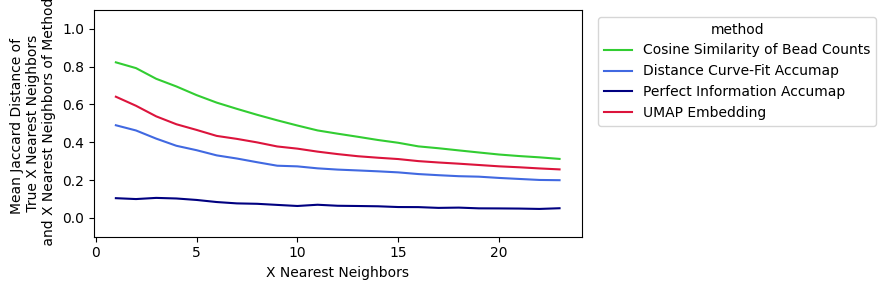

In [ ]:
plt.figure(figsize=(9, 3))
ax = sns.lineplot(new_median_nn.groupby(['method', 'nn']).mean().reset_index(), x = 'nn', y = 'jac', hue = 'method',
                  palette = {'UMAP Embedding': 'crimson', 
                  'Perfect Information Accumap' : 'navy',
       'Cosine Similarity of Bead Counts' : 'limegreen',
                  'Distance Curve-Fit Accumap' : 'royalblue'}
         )
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1.02, 1))
ax.set_xlabel('X Nearest Neighbors')
ax.set_ylabel('Mean Jaccard Distance of \n True X Nearest Neighbors \n and X Nearest Neighbors of Method')

plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('../final_figures/Supp2c.png')
plt.show()

In [46]:
new_median_nn.groupby('method')['jac'].mean()

method
Cosine Similarity of Bead Counts    0.492279
Distance Curve-Fit Accumap          0.285425
Perfect Information Accumap         0.069369
UMAP Embedding                      0.373334
Name: jac, dtype: float64

In [57]:
embed_list = [fit_accumap.values]
name_list = ['Distance Curve-Fit Accumap']

bar_n = adata.obs.shape[0]
error_list = []
method_list = []
bead_list = len(embed_list)* np.arange(bar_n).tolist()

for embed, name in zip(embed_list, name_list):
    print(name)
    error_list += get_error_metrics(embed, adata.obs[['xcoord', 'ycoord']]).tolist()
    method_list += bar_n*[name]

small_df = pd.DataFrame({'error':error_list,
                         'method':method_list,
                         'bead':bead_list})
new_error_df = pd.concat([error_df, small_df])
new_error_df.head()

Distance Curve-Fit Accumap


,error,method,bead
0,2283.436174,UMAP Embedding,0
1,4227.981515,UMAP Embedding,1
2,2127.235600,UMAP Embedding,2
3,2142.327369,UMAP Embedding,3
4,2631.717039,UMAP Embedding,4


In [58]:
new_error_df.groupby('method')['error'].mean()

method
Distance Curve-Fit Accumap     2068.603012
Perfect Information Accumap     410.105144
UMAP Embedding                 4132.429721
Name: error, dtype: float64

In [59]:
new_error_df.groupby('method')['error'].median()

method
Distance Curve-Fit Accumap     1686.164460
Perfect Information Accumap     354.450285
UMAP Embedding                 3299.852783
Name: error, dtype: float64

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_summary_fig(old1, new1, 
                     color1, color2,
                     name1='', name2='',
                     cbar_label='MSE'):

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 6))

    def scatter_with_cbar(ax, x, y, c, title):
        im = ax.scatter(x, y, c=c, alpha=1, s=1)
        ax.set_title(title, fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="4%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=5)
        cbar.set_label(cbar_label, fontsize=7)

    scatter_with_cbar(ax1, old1.xcoord.values, old1.ycoord.values, color1, name1)
    scatter_with_cbar(ax2, new1.xcoord.values, new1.ycoord.values, color2, name2)

    for ax in (ax1, ax2):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=5)

    fig.tight_layout(pad=2)
    plt.show()

    return fig


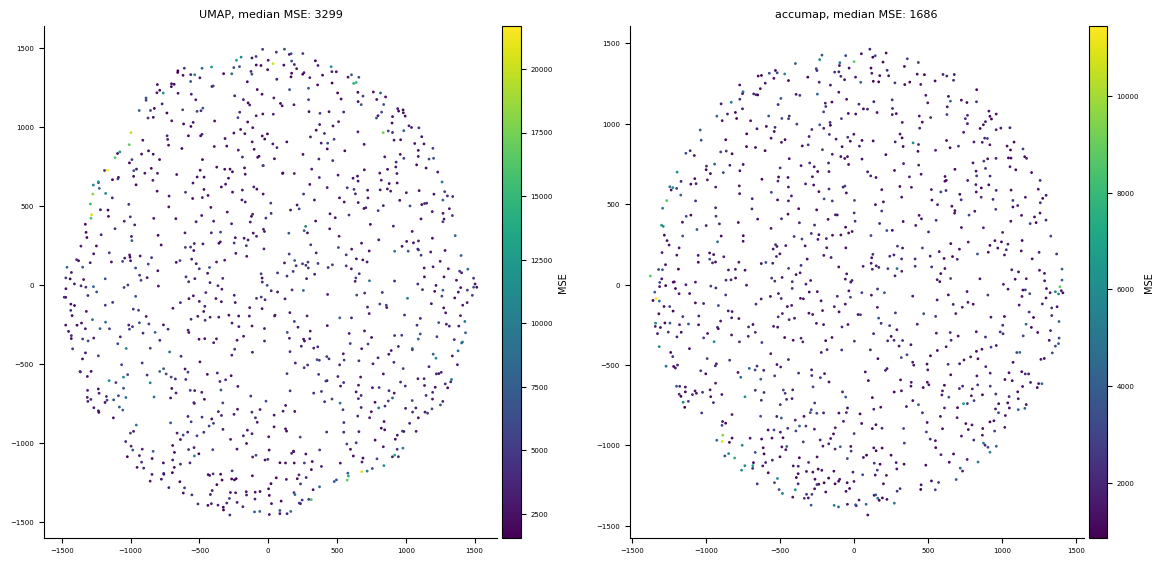

In [ ]:
p = make_summary_fig(pd.DataFrame(embedding, columns = ['xcoord', 'ycoord']), 
                     fit_accumap, 
                     new_error_df[new_error_df.method == 'UMAP Embedding']['error'].values,
                     new_error_df[new_error_df.method == 'Distance Curve-Fit Accumap']['error'].values, 
                         name1=f'UMAP, median MSE: {int(new_error_df.groupby('method')['error'].median()['UMAP Embedding'])}', 
                     name2=f'accumap, median MSE: {int(new_error_df.groupby('method')['error'].median()['Distance Curve-Fit Accumap'])}')
p.savefig('../final_figures/Supp2a.png')

In [13]:

embed_list = [embedding, fit_accumap.values]
name_list = ['UMAP Embedding', 'Distance Curve-Fit Accumap']

bar_n = adata.obs.shape[0]*adata.obs.shape[0]
error_list = []
method_list = []
distance_list = []
bead_list = len(embed_list)*adata.obs.shape[0]* np.arange(adata.obs.shape[0]).tolist()

for embed, name in zip(embed_list, name_list):
    print(name)
    error_list += get_error_metrics(embed, adata.obs[['xcoord', 'ycoord']], mean_err=False).flatten().tolist()
    method_list += bar_n*[name]
    distance_list += truth_dist.flatten().tolist()

bigger_error_df = pd.DataFrame({'Squared Error of Distance in Embedding':error_list,
                                'True Bead-to-Bead Distance' : distance_list})


NameError: name 'fit_accumap' is not defined

In [63]:
#plt.figure(figsize=(3, 9))
#p = sns.relplot(bigger_error_df, x = 'True Bead-to-Bead Distance', y = 'Squared Error of Distance in Embedding', col = 'method', col_wrap = 1
#         )
#p.tight_layout()
#plt.show()